In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_palette('RdYlGn')

#model
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

import gradio as gr
import joblib

In [4]:
df = pd.read_csv("/content/Nigerian_Car_Prices.csv")

In [5]:
df.head()

,Unnamed: 0,Make,Year of manufacture,Condition,Mileage,Engine Size,Fuel,Transmission,Price,Build
0,0,Toyota,2007.0,Nigerian Used,166418.0,2400.0,Petrol,Automatic,"3,120,000",NaN
1,1,Lexus,NaN,NaN,138024.0,NaN,NaN,Automatic,"5,834,000",NaN
2,2,Mercedes-Benz,2008.0,Nigerian Used,376807.0,3000.0,Petrol,Automatic,"3,640,000",NaN
3,3,Lexus,NaN,NaN,213362.0,NaN,NaN,Automatic,"3,594,000",NaN
4,4,Mercedes-Benz,NaN,NaN,106199.0,NaN,NaN,Automatic,"8,410,000",NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4095 entries, 0 to 4094
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           4095 non-null   int64  
 1   Make                 4095 non-null   object 
 2   Year of manufacture  3617 non-null   float64
 3   Condition            3616 non-null   object 
 4   Mileage              4024 non-null   float64
 5   Engine Size          3584 non-null   float64
 6   Fuel                 3607 non-null   object 
 7   Transmission         4075 non-null   object 
 8   Price                4095 non-null   object 
 9   Build                1127 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 320.0+ KB


### Data Cleaning

In [7]:
df = df.drop('Build', axis = 1)

In [8]:
df = df.dropna()

In [9]:
df.shape

(3523, 9)

In [10]:
df['Price'] = df['Price'].str.replace(',', '') 
df['Price'] = df['Price'].astype(float)  

df['Year of manufacture'] = df['Year of manufacture'].astype(int)  

In [11]:
df.describe()

,Unnamed: 0,Year of manufacture,Mileage,Engine Size,Price
count,3523.000000,3523.000000,3.523000e+03,3523.000000,3.523000e+03
mean,2089.276753,2007.921090,1.901794e+05,3170.591541,4.060590e+06
std,1187.608368,4.303771,2.215162e+05,4641.379934,4.520306e+06
min,0.000000,1992.000000,1.000000e+00,3.000000,4.725000e+05
25%,1066.500000,2005.000000,1.070360e+05,2000.000000,1.800000e+06
50%,2085.000000,2008.000000,1.670060e+05,2500.000000,2.835000e+06
75%,3136.500000,2011.000000,2.397715e+05,3500.000000,4.500000e+06
max,4094.000000,2021.000000,9.976050e+06,184421.000000,5.880000e+07


### EDA

### Feature Engineering

In [35]:
#the brand new is just 5, it will be drop
# Dropping the 'Brand New' category
df = df[df['Condition'] != 'Brand New']

In [38]:
X = df.drop(['Unnamed: 0', 'Price'], axis = 1)
y = df.Price

make_counts = X['Make'].value_counts()


# Get the values to replace with 'Others'
make_others = make_counts[make_counts < 14].index.tolist()

# Replace values with 'Others'
X['Make'] = X['Make'].apply(lambda x: 'Others' if x in make_others else x)

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state=10)


# Initializing the encoders and scaler for each column
make_encoder = LabelEncoder()
fuel_encoder = LabelEncoder()
transmission_encoder = LabelEncoder()
condition_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Encoding and scaling each column individually
X_train['Make'] = make_encoder.fit_transform(X_train['Make'])
X_test['Make'] = make_encoder.transform(X_test['Make'])

X_train['Fuel'] = fuel_encoder.fit_transform(X_train['Fuel'])
X_test['Fuel'] = fuel_encoder.transform(X_test['Fuel'])

X_train['Transmission'] = transmission_encoder.fit_transform(X_train['Transmission'])
X_test['Transmission'] = transmission_encoder.transform(X_test['Transmission'])

X_train['Condition'] = condition_encoder.fit_transform(X_train['Condition'])
X_test['Condition'] = condition_encoder.transform(X_test['Condition'])

X_train[['Year of manufacture', 'Mileage', 'Engine Size']] = scaler.fit_transform(X_train[['Year of manufacture', 'Mileage', 'Engine Size']])
X_test[['Year of manufacture', 'Mileage', 'Engine Size']] = scaler.transform(X_test[['Year of manufacture', 'Mileage', 'Engine Size']])

# Save the encoders and scaler
joblib.dump(make_encoder, "make_encoder.joblib",compress=3)
joblib.dump(fuel_encoder, "fuel_encoder.joblib",compress=3)
joblib.dump(transmission_encoder, "transmission_encoder.joblib",compress=3)
joblib.dump(condition_encoder, "condition_encoder.joblib",compress=3)
joblib.dump(scaler, "scaler.joblib",compress=3)

['scaler.joblib']

#### Needed Model

In [39]:
# Initialize the models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
lr_model = LinearRegression()

# Fit the models on the training data
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Make predictions on the testing data
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

# Evaluate the models using root mean squared error (RMSE)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)

# Print the RMSE scores
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"Linear Regression RMSE: {lr_rmse:.2f}")

Random Forest RMSE: 1900923.15
XGBoost RMSE: 1881430.11
Linear Regression RMSE: 3227815.24


In [40]:
#  R2 score
rf_r2 = r2_score(y_test, rf_preds)
print("Random Forest R2 Score:", rf_r2)


xgb_r2 = r2_score(y_test, xgb_preds)
print("XGBoost R2 Score:", xgb_r2)


lr_r2 = r2_score(y_test, lr_preds)
print("Linear Regression R2 Score:", lr_r2)


Random Forest R2 Score: 0.7692007346747749
XGBoost R2 Score: 0.7739099336774033
Linear Regression R2 Score: 0.33453895627915986


In [41]:
joblib.dump(xgb_model, "car_model.joblib", compress=3)

['car_model.joblib']

**Note: Many Models have been built, but only the needed ones were kept**

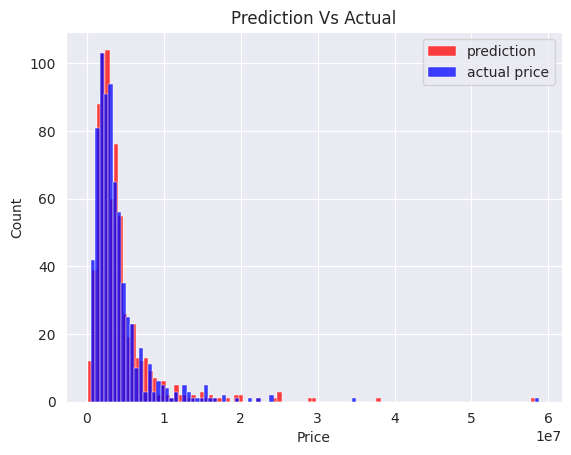

In [42]:
sns.histplot(xgb_preds, label='prediction',color='red')
sns.histplot(y_test, label='actual price', color = 'blue')
plt.title('Prediction Vs Actual')
plt.legend()
plt.show()

### Prediction

In [43]:
import joblib
def predict_car_price(make, year, condition, mileage, engine_size, fuel, transmission):
    # Load the encoders and scaler
    make_encoder = joblib.load("make_encoder.joblib")
    fuel_encoder = joblib.load("fuel_encoder.joblib")
    transmission_encoder = joblib.load("transmission_encoder.joblib")
    condition_encoder = joblib.load("condition_encoder.joblib")
    scaler = joblib.load("scaler.joblib")

    # Preprocess the input
    make_encoded = make_encoder.transform([make])[0]
    numerical_value = scaler.transform([[year,mileage, engine_size]])
    year_scaled = numerical_value[0][0]
    mileage_scaled = numerical_value[0][1]
    engine_size_scaled = numerical_value[0][2]
    fuel_encoded = fuel_encoder.transform([fuel])[0]
    condition_encoded = condition_encoder.transform([condition])[0]
    transmission_encoded = transmission_encoder.transform([transmission])[0]

    input_data = [[make_encoded, year_scaled, condition_encoded, mileage_scaled, engine_size_scaled, fuel_encoded, transmission_encoded]]
    input_df = pd.DataFrame(input_data, columns=['Make', 'Year of manufacture', 'Condition', 'Mileage', 'Engine Size', 'Fuel', 'Transmission'])

    # Make predictions
    predicted_price = xgb_model.predict(input_df)
    return round(predicted_price[0], 2)

In [44]:
predict_car_price('Toyota', 2010,'Nigerian Used', 3000, 2300, 'Petrol', 'Automatic')

4970118.0

### Gradio Interface

In [46]:
import gradio as gr
import joblib
def predict_car_price(make, year, condition, mileage, engine_size, fuel, transmission):
    # Load the encoders and scaler
    make_encoder = joblib.load("make_encoder.joblib")
    fuel_encoder = joblib.load("fuel_encoder.joblib")
    transmission_encoder = joblib.load("transmission_encoder.joblib")
    condition_encoder = joblib.load("condition_encoder.joblib")
    scaler = joblib.load("scaler.joblib")

    make_encoded = make_encoder.transform([make])[0]
    numerical_value = scaler.transform([[year,mileage, engine_size]])
    year_scaled = numerical_value[0][0]
    mileage_scaled = numerical_value[0][1]
    engine_size_scaled = numerical_value[0][2]
    fuel_encoded = fuel_encoder.transform([fuel])[0]
    condition_encoded = condition_encoder.transform([condition])[0]
    transmission_encoded = transmission_encoder.transform([transmission])[0]
    input_data = [[make_encoded, year_scaled, condition_encoded, mileage_scaled, engine_size_scaled, fuel_encoded, transmission_encoded]]
    input_df = pd.DataFrame(input_data, columns=['Make', 'Year of manufacture', 'Condition', 'Mileage', 'Engine Size', 'Fuel', 'Transmission'])

    # Make predictions
    predicted_price = xgb_model.predict(input_df)
    return round(predicted_price[0], 2)
make_dropdown = gr.inputs.Dropdown(['Acura', 'Audi', 'BMW', 'Chevrolet', 'Dodge', 'Ford', 'Honda',
       'Hyundai', 'Infiniti', 'Kia', 'Land Rover', 'Lexus', 'Mazda',
       'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Peugeot',
       'Pontiac', 'Toyota', 'Volkswagen', 'Volvo'], label="Make")
condition_dropdown = gr.inputs.Dropdown(['Foreign Used', 'Nigerian Used'], label="Condition")
fuel_dropdown = gr.inputs.Dropdown(["Petrol", "Diesel", "Electric"], label="Fuel")
transmission_dropdown = gr.inputs.Dropdown(["Manual", "Automatic", "AMT"], label="Transmission")
year_slider = gr.inputs.Slider(minimum=1992, maximum=2021, step=1, default=2010, label="Year")
mileage_slider = gr.inputs.Slider(minimum=1, maximum=300000, step=10, default=80000, label="Mileage")
engine_size_slider = gr.inputs.Slider(minimum=1, maximum=20000, step=1, default=100, label="Engine Size")

iface = gr.Interface(
fn=predict_car_price,
inputs=[make_dropdown, year_slider, condition_dropdown, mileage_slider, engine_size_slider, fuel_dropdown, transmission_dropdown],
outputs="number",
title="Car Price Prediction",
    description="Predict the price of a car based on its details, in Naira.",
    examples=[
        ["Toyota", 2010, "Nigerian Used", 80000, 2.0, "Petrol", "Automatic"],
        ["Mercedes-Benz", 2015, "Foreign Used", 50000, 1000, "Diesel", "AMT"],
    ],css=".gradio-container {background-color: lightgreen}"
)

iface.launch(share = True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://99918e8c858d7db896.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
